In [44]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [45]:
FIG_DIR, TAB_DIR = "../results/figures", "../results/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)


In [46]:

DATA_PATH = "../data/raw/total_dataset.csv"
df = pd.read_csv(DATA_PATH, dtype=str, keep_default_na=False, low_memory=False)
df.head()


,AppName,Review ID,CustomerReplyContent,Score,Thumbsupcount,PlatformReply
0,Amazon shopping,a8bab7d7-d03a-4257-a922-15b0540c9e58,"I have to update my review on this company, th...",2,993,
1,Amazon shopping,0da41c37-6d79-451d-a665-b2797d3a5c2f,The Amazon App has suddenly stopped showing al...,2,990,
2,Amazon shopping,fddb6b4a-d73e-4aa9-b797-91d7d77d33e3,"I really hate the new AI feature (""Rufus""). Th...",2,99,
3,Amazon shopping,00f81af4-b723-430e-8636-732909c592f1,Wow the new design layout is so stupid! Now I ...,2,99,
4,Amazon shopping,ef5a4898-d90b-4218-83d8-a951b3018d73,Since one of the recent updates I can no longe...,1,99,


In [47]:
def basic_clean(s: str) -> str:
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)      # URL
    s = re.sub(r"&(?:amp|nbsp|lt|gt);", " ", s)       # HTML 残留
    s = re.sub(r"[@#][A-Za-z0-9_]+", " ", s)          # @mention / #hashtag
    s = re.sub(r"[^A-Za-z0-9'\s]", " ", s)            # 非字母数字删掉（保留撇号）
    s = re.sub(r"\s+", " ", s).strip().lower()        # 挤空格 + 小写
    return s

df["text_clean"] = df["CustomerReplyContent"].apply(basic_clean)
df = df[df["text_clean"].astype(bool)].reset_index(drop=True)
df[["AppName","text_clean"]].head(3)

,AppName,text_clean
0,Amazon shopping,i have to update my review on this company the...
1,Amazon shopping,the amazon app has suddenly stopped showing al...
2,Amazon shopping,i really hate the new ai feature rufus the fac...


In [48]:
df["tokens"] = df["text_clean"].str.findall(r"[a-z0-9']+")

# 每条评论拆成多个 token 行
tok = (
    df[["AppName","tokens"]]
    .explode("tokens")
    .rename(columns={"tokens":"word"})
    .reset_index(drop=True)
)

tok.head(10)

,AppName,word
0,Amazon shopping,i
1,Amazon shopping,have
2,Amazon shopping,to
3,Amazon shopping,update
4,Amazon shopping,my
5,Amazon shopping,review
6,Amazon shopping,on
7,Amazon shopping,this
8,Amazon shopping,company
9,Amazon shopping,they


In [49]:
# 小而简的英语停用词（你可以继续往里加）
stop_small = {
    "a","an","the","and","or","of","to","in","for","on","with","at","by","from","as",
    "is","am","are","was","were","be","been","being",
    "it","this","that","these","those","i","me","my","we","our","you","your","he","she","they","them",
    "im","dont","ive","youre","hes","shes","theyre","cant","couldnt","didnt","doesnt","isnt","wasnt","werent",
    "just","so","too","very","also","but","if","not","not","now","then","there","here","when","where","why","how",
    "all","any","some","no","more","most","many","much","such",
    "what","which","who","whom","whose",
    "than","about","into","like","over","after","before","between","through","during","because","something",
    "have","has","had","having","do","does","did","doing"
}

# 评论里常见但信息量低的词（系统/操作/客套话等）
review_stop = {
    "use","using","update","updated","app","apps","version","android","iphone","ios","can","cannot","could","can't"
    "download","install","installed","login","account","please","thanks","thank","review"
    "bug","work","working","does","did","still","time","day","new","old","have","say","will","even"
}

# 平台名和泛词（避免占榜）
platform_stop = {
    "amazon","ebay","lazada","shein","get","got","also","one","two","really",
    "buy","bought","order","ordered","orders","product","item","it's"
}

ban = stop_small | review_stop | platform_stop

# 规则：长度≥3、包含字母或数字、且不在 ban 里
tok = tok[
    (tok["word"].str.len() >= 3) &
    (tok["word"].str.contains(r"[a-z0-9]")) &
    (~tok["word"].isin(ban))
].reset_index(drop=True)

tok.head(30)



,AppName,word
0,Amazon shopping,review
1,Amazon shopping,company
2,Amazon shopping,suck
3,Amazon shopping,can't
4,Amazon shopping,depend
5,Amazon shopping,supposed
6,Amazon shopping,delivered
7,Amazon shopping,same
8,Amazon shopping,delivery
9,Amazon shopping,don't


In [50]:
word_counts = (
    tok.groupby(["AppName","word"]).size()
      .reset_index(name="count")
      .sort_values(["AppName","count"], ascending=[True, False])
)

# 每个平台看前 10 行
word_counts.groupby("AppName").head(10)



,AppName,word,count
18386,Amazon shopping,love,11080
27193,Amazon shopping,shopping,10632
23320,Amazon shopping,prime,10601
26826,Amazon shopping,service,10451
14100,Amazon shopping,great,10071
5827,Amazon shopping,can't,9830
10127,Amazon shopping,don't,9616
9007,Amazon shopping,delivery,9234
16754,Amazon shopping,items,9183
13888,Amazon shopping,good,8713


In [51]:

TOPK = 15
top_words = word_counts.groupby("AppName").head(TOPK).reset_index(drop=True)

top_words.head(20)


,AppName,word,count
0,Amazon shopping,love,11080
1,Amazon shopping,shopping,10632
2,Amazon shopping,prime,10601
3,Amazon shopping,service,10451
4,Amazon shopping,great,10071
5,Amazon shopping,can't,9830
6,Amazon shopping,don't,9616
7,Amazon shopping,delivery,9234
8,Amazon shopping,items,9183
9,Amazon shopping,good,8713


In [52]:
TOPK = 50

word_counts_sorted = (
    word_counts.sort_values(["AppName","count"], ascending=[True, False])
)

top50_words = (
    word_counts_sorted.groupby("AppName", group_keys=False).head(TOPK)
    .reset_index(drop=True)
)

top50_words.head(10), top50_words.shape

(           AppName      word  count
 0  Amazon shopping      love  11080
 1  Amazon shopping  shopping  10632
 2  Amazon shopping     prime  10601
 3  Amazon shopping   service  10451
 4  Amazon shopping     great  10071
 5  Amazon shopping     can't   9830
 6  Amazon shopping     don't   9616
 7  Amazon shopping  delivery   9234
 8  Amazon shopping     items   9183
 9  Amazon shopping      good   8713,
 (200, 3))

In [53]:
TAB_DIR = TAB_DIR if "TAB_DIR" in globals() else "../results/tables"
os.makedirs(TAB_DIR, exist_ok=True)

out_path = f"{TAB_DIR}/top50_words_by_platform.csv"
top50_words.to_csv(out_path, index=False)
print("saved to:", out_path)

saved to: ../results/tables/top50_words_by_platform.csv


/var/folders/d6/q_01hrks467_v64tf_kb3lrh0000gn/T/ipykernel_51854/1061167708.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


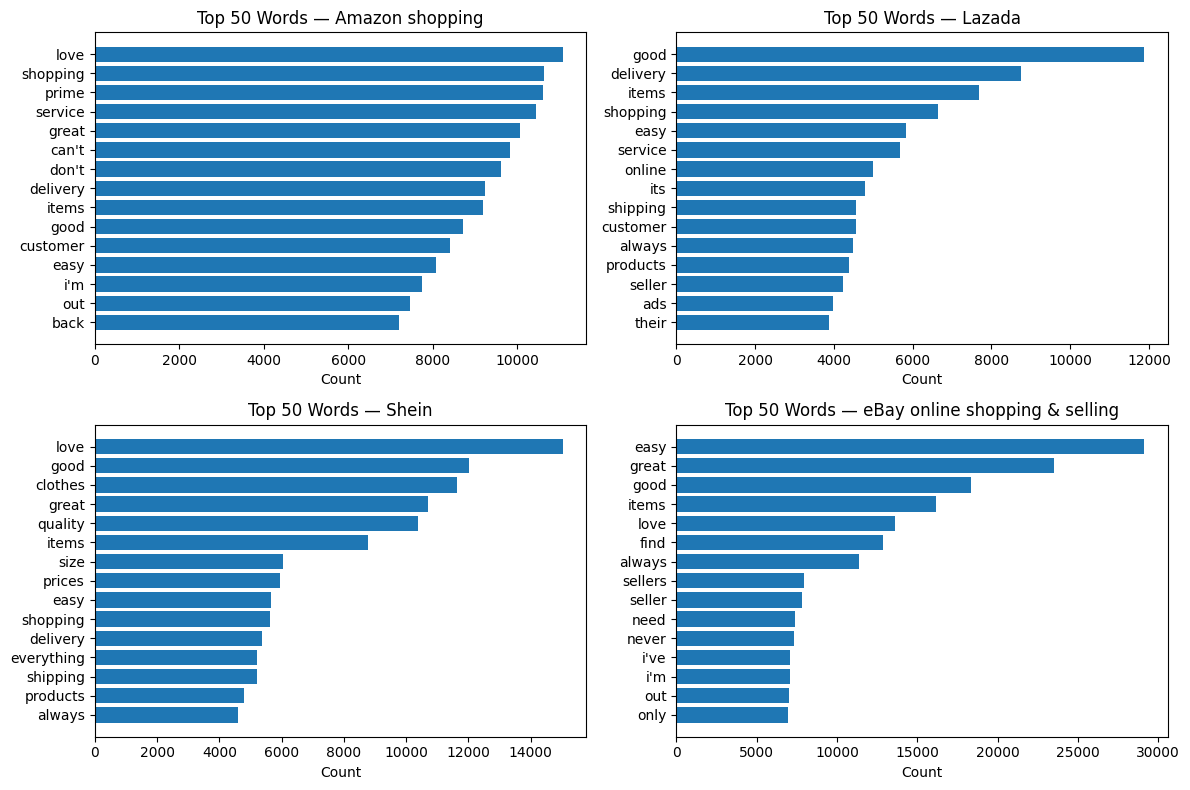

In [54]:
plats = top_words["AppName"].unique().tolist()
n = len(plats)
ncols = 2
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(12, 4*nrows))
for i, p in enumerate(plats, 1):
    sub = top_words[top_words["AppName"] == p].sort_values("count")
    plt.subplot(nrows, ncols, i)
    plt.barh(sub["word"], sub["count"])
    plt.title(f"Top {TOPK} Words — {p}")
    plt.xlabel("Count")
    plt.tight_layout()

plt.savefig(f"{FIG_DIR}/top_words_by_platform.png", dpi=300, bbox_inches="tight")
plt.show()


## TF-IDF Term Frequency – Inverse Document Frequency

In [55]:
# ① 评论里常见但信息量低的词（在 TF-IDF 前先排除）
generic_words = {
    # 评价类高频形容词/副词
    "good","great","nice","easy","best","better","amazing","awesome","bad","worst",
    "ok","okay","fine","cool","love","like","dislike",
    # 通用名词/动词
    "app","apps","product","products","item","items","thing","things","stuff",
    "customer","service","support","help","people","user","users",
    "shopping","shop","buy","bought","sell","seller","sellers",
    "use","using","used","work","working","does","did","done","make","made",
    "time","day","days","now","today","version",
    # 客套/连接词
    "please","thanks","thank","hi","hello","yes","no","also","still","really","very"
}

# ② 轻量“词形/同义词”标准化（够用就好）
normalize_map = {
    "refunds":"refund","refunded":"refund","refunding":"refund",
    "returns":"return","returned":"return","returning":"return",
    "deliveries":"delivery","delivered":"delivery","delivering":"delivery",
    "shipping":"ship","shipped":"ship","ships":"ship",
    "sizes":"sizing","sized":"sizing",
    "prices":"price","pricey":"price",
    "vouchers":"voucher","promos":"promo","promotions":"promo",
    "coupons":"coupon",
    "memberships":"membership","primevideo":"prime","primegaming":"prime",
    "auctions":"auction","bids":"bid","bidding":"bid"
}

def normalize_word(w: str) -> str:
    w = w.lower()
    if w in normalize_map: 
        return normalize_map[w]
    # 朴素单复数合并：长词尾部的 's' 去掉（避免把 'is' 之类短词误杀）
    if len(w) > 4 and w.endswith("s") and not w.endswith("ss"):
        return w[:-1]
    return w



In [56]:
# 你已有的 tok: ['AppName','word']（来自前面的分词 + 基本停用词过滤）
tok_refined = tok.copy()
tok_refined["word"] = tok_refined["word"].str.lower().map(normalize_word)

# 去掉“泛词”
tok_refined = tok_refined[~tok_refined["word"].isin(generic_words)]

# （可选）去非常罕见的词，减少噪声：全局出现次数 < 30 的忽略
min_count = 30
freq_all = tok_refined["word"].value_counts()
keep = set(freq_all[freq_all >= min_count].index)
tok_refined = tok_refined[tok_refined["word"].isin(keep)].reset_index(drop=True)

tok_refined.head(10)



,AppName,word
0,Amazon shopping,review
1,Amazon shopping,company
2,Amazon shopping,suck
3,Amazon shopping,can't
4,Amazon shopping,depend
5,Amazon shopping,supposed
6,Amazon shopping,delivery
7,Amazon shopping,same
8,Amazon shopping,delivery
9,Amazon shopping,don't


In [57]:
import numpy as np
import pandas as pd

# TF 的分子：某平台该词的出现次数
tf_count = (
    tok_refined.groupby(["AppName","word"])
               .size()
               .reset_index(name="count")
)

# TF 的分母：该平台全部 token 数
tokens_per_app = (
    tok_refined.groupby("AppName").size()
               .reset_index(name="total_tokens")
)

tf = tf_count.merge(tokens_per_app, on="AppName", how="left")
tf["tf"] = tf["count"] / tf["total_tokens"]

# DF：该词出现在多少个平台
platforms = tf["AppName"].nunique()
df_word = (tf.groupby("word")["AppName"].nunique()
             .reset_index(name="df_platforms"))

# IDF（平滑）
tfidf = tf.merge(df_word, on="word", how="left")
tfidf["idf"] = np.log((platforms + 1) / (tfidf["df_platforms"] + 1)) + 1
tfidf["tfidf"] = tfidf["tf"] * tfidf["idf"]

tfidf.head(5)



,AppName,word,count,total_tokens,tf,df_platforms,idf,tfidf
0,Amazon shopping,'add,19,1143275,0.000017,3,1.223144,0.000020
1,Amazon shopping,'cause,5,1143275,0.000004,4,1.000000,0.000004
2,Amazon shopping,'my,12,1143275,0.000010,3,1.223144,0.000013
3,Amazon shopping,000,108,1143275,0.000094,4,1.000000,0.000094
4,Amazon shopping,100,624,1143275,0.000546,4,1.000000,0.000546


saved: ../results/tables/top_tfidf_refined_by_platform.csv


/var/folders/d6/q_01hrks467_v64tf_kb3lrh0000gn/T/ipykernel_51854/2003068331.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


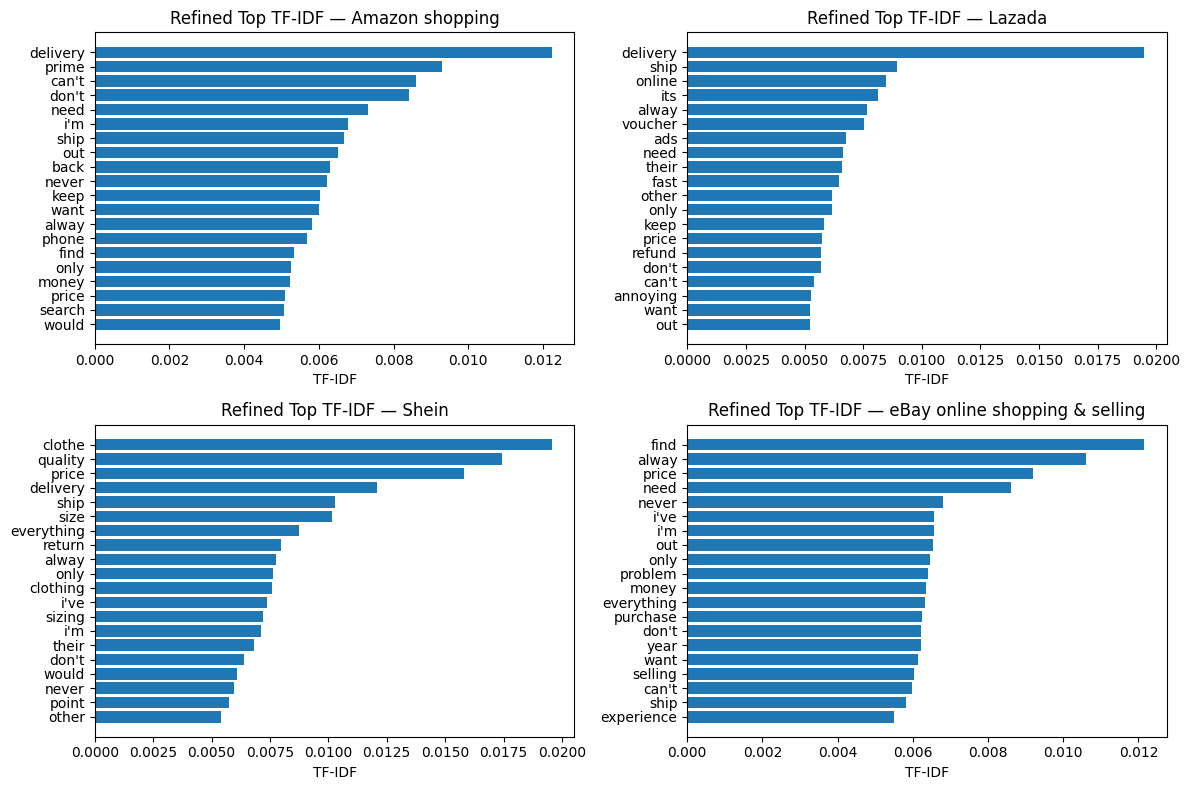

In [58]:
TOPK_TFIDF = 20

tfidf_sorted = tfidf.sort_values(["AppName","tfidf"], ascending=[True, False])
top_tfidf_refined = (
    tfidf_sorted.groupby("AppName", group_keys=False).head(TOPK_TFIDF)
    [["AppName","word","count","tf","idf","tfidf"]]
    .reset_index(drop=True)
)

# 保存
top_tfidf_refined.to_csv(f"{TAB_DIR}/top_tfidf_refined_by_platform.csv", index=False)
print("saved:", f"{TAB_DIR}/top_tfidf_refined_by_platform.csv")

# 画图
import matplotlib.pyplot as plt
apps = top_tfidf_refined["AppName"].unique().tolist()
n = len(apps); ncols = 2; nrows = (n + ncols - 1)//ncols

plt.figure(figsize=(12, 4*nrows))
for i, app in enumerate(apps, 1):
    sub = top_tfidf_refined[top_tfidf_refined["AppName"]==app].sort_values("tfidf")
    plt.subplot(nrows, ncols, i)
    plt.barh(sub["word"], sub["tfidf"])
    plt.title(f"Refined Top TF-IDF — {app}")
    plt.xlabel("TF-IDF")
    plt.tight_layout()

plt.savefig(f"{FIG_DIR}/top_tfidf_refined_by_platform.png", dpi=300, bbox_inches="tight")
plt.show()


In [59]:
FIG_DIR = globals().get("FIG_DIR", "../results/figures")
TAB_DIR = globals().get("TAB_DIR", "../results/tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
def savefig(path, dpi=300, tight=True):
    if tight:
        plt.savefig(path, dpi=dpi, bbox_inches="tight")
    else:
        plt.savefig(path, dpi=dpi)
    print(f"[fig] saved -> {path}")

# 小工具：安全保存表
def savetab(df, path):
    df.to_csv(path, index=False)
    print(f"[csv] saved -> {path}")

**Comparative Analysis**

In [60]:
word_counts = (
    tok.groupby(["AppName","word"]).size()
       .reset_index(name="count")
)

tokens_per_app = (
    tok.groupby("AppName").size()
       .reset_index(name="total_tokens")
)

wc = word_counts.merge(tokens_per_app, on="AppName", how="left")
wc["per_1k"] = (1000 * wc["count"] / wc["total_tokens"]).astype(float)


savetab(wc.sort_values(["AppName","per_1k"], ascending=[True, False]),
        os.path.join(TAB_DIR, "top_words_per1k_by_app.csv"))



[csv] saved -> ../results/tables/top_words_per1k_by_app.csv


[csv] saved -> ../results/tables/top_bigrams_per1k_by_app.csv
[fig] saved -> ../results/figures/top_bigrams_per1k_by_app.png


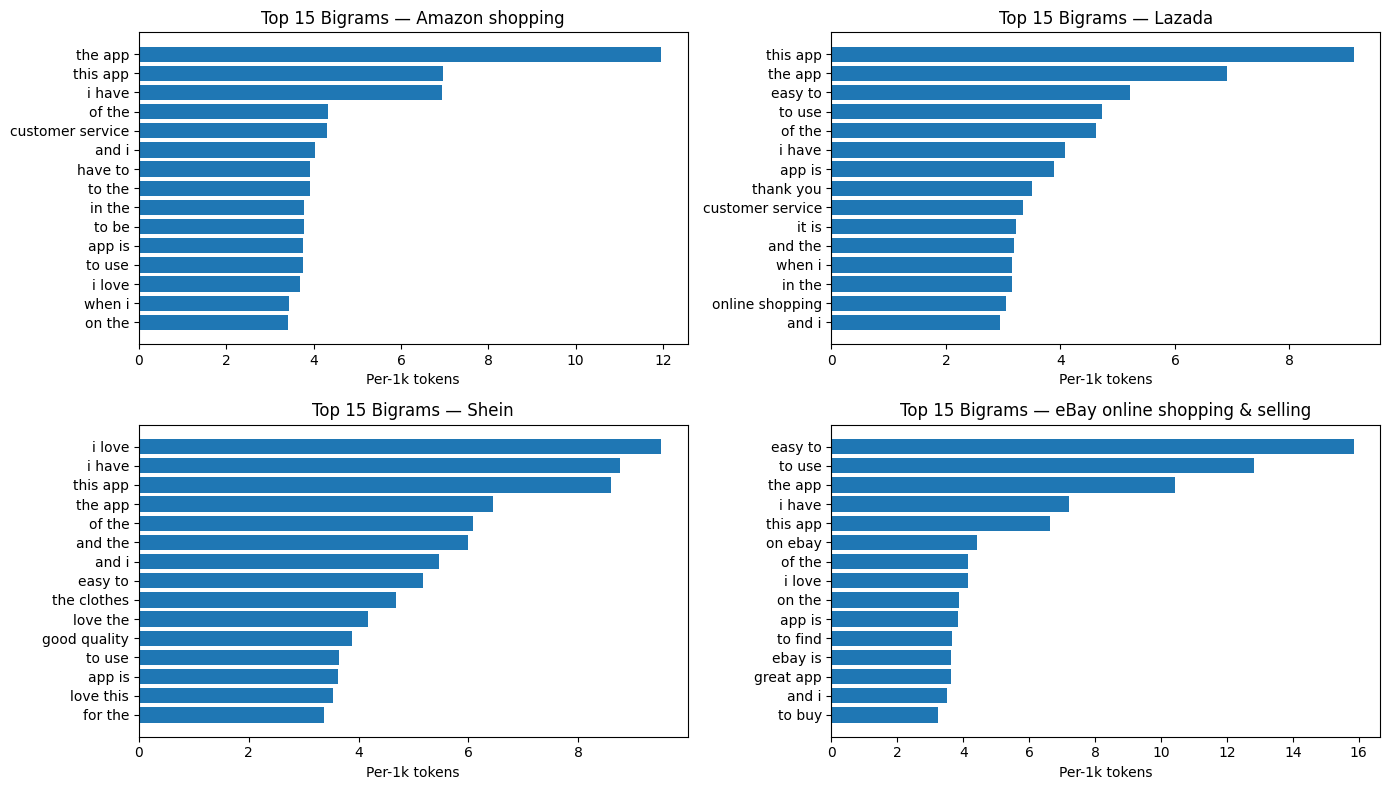

In [61]:
# Bigram：计数
if "bigrams_df" not in globals():
    def _doc_bigrams(toks): 
        toks = toks if isinstance(toks, list) else []
        return [" ".join(p) for p in zip(toks, toks[1:])]
    bigrams_df = (
        df.loc[:, ["AppName", "tokens"]]
          .assign(_bg=lambda x: x["tokens"].apply(_doc_bigrams))
          .explode("_bg").dropna()
          .rename(columns={"_bg":"bigram"})
          .reset_index(drop=True)
    )

big = bigrams_df

if "tokens_per_app" not in globals():
    tokens_per_app = tok.groupby("AppName").size().reset_index(name="total_tokens")

big_counts = (
    big.groupby(["AppName","bigram"]).size()
       .reset_index(name="count")
    .merge(tokens_per_app, on="AppName", how="left")
)
big_counts["per_1k"] = (1000 * big_counts["count"] / big_counts["total_tokens"]).astype(float)

savetab(big_counts.sort_values(["AppName","per_1k"], ascending=[True, False]),
        os.path.join(TAB_DIR, "top_bigrams_per1k_by_app.csv"))

def plot_top_bigrams_per1k(bg, topn=15, fname="top_bigrams_per1k_by_app.png"):
    apps = bg["AppName"].unique().tolist()
    n = len(apps); ncols = 2; nrows = (n + ncols - 1)//ncols
    plt.figure(figsize=(14, 4*nrows))
    for i, app in enumerate(apps, 1):
        sub = bg[bg["AppName"]==app].nlargest(topn, "per_1k").sort_values("per_1k")
        plt.subplot(nrows, ncols, i)
        plt.barh(sub["bigram"], sub["per_1k"])
        plt.xlabel("Per-1k tokens")
        plt.title(f"Top {topn} Bigrams — {app}")
    plt.tight_layout()
    savefig(os.path.join(FIG_DIR, fname))

plot_top_bigrams_per1k(big_counts, topn=15, fname="top_bigrams_per1k_by_app.png")


[csv] saved -> ../results/tables/tfidf_by_app.csv
[fig] saved -> ../results/figures/top_tfidf_by_app.png


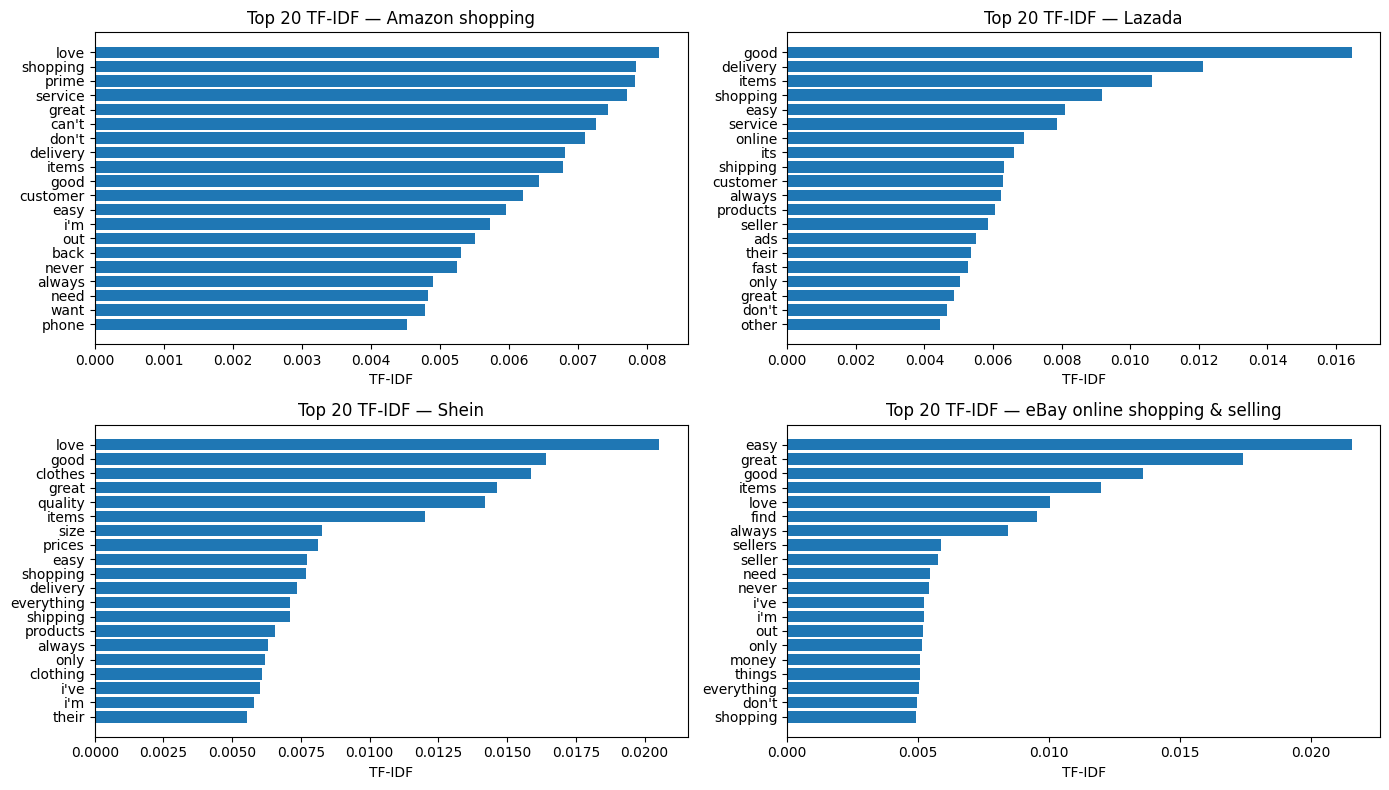

In [62]:
# TF-IDF（若你们已有 tfidf，就跳过计算并直接可视化）
def compute_tfidf_from_tokens(tok_df):
    tf_count = tok_df.groupby(["AppName","word"]).size().reset_index(name="count")
    tokens_per_app = tok_df.groupby("AppName").size().reset_index(name="total_tokens")
    tf = tf_count.merge(tokens_per_app, on="AppName", how="left")
    tf["tf"] = tf["count"] / tf["total_tokens"]

    platforms = tok_df["AppName"].nunique()
    df_word = tf.groupby("word")["AppName"].nunique().reset_index(name="df_platforms")
    tfidf = tf.merge(df_word, on="word", how="left")
    tfidf["idf"] = np.log((platforms + 1) / (tfidf["df_platforms"] + 1)) + 1
    tfidf["tfidf"] = tfidf["tf"] * tfidf["idf"]
    return tfidf

tfidf = compute_tfidf_from_tokens(tok) 
savetab(tfidf, os.path.join(TAB_DIR, "tfidf_by_app.csv"))

def plot_top_tfidf(tfidf_df, topn=20, fname="top_tfidf_by_app.png"):
    apps = tfidf_df["AppName"].unique().tolist()
    n = len(apps); ncols = 2; nrows = (n + ncols - 1)//ncols
    plt.figure(figsize=(14, 4*nrows))
    for i, app in enumerate(apps, 1):
        sub = (tfidf_df[tfidf_df["AppName"]==app]
               .nlargest(topn, "tfidf")
               .sort_values("tfidf"))
        plt.subplot(nrows, ncols, i)
        plt.barh(sub["word"], sub["tfidf"])
        plt.xlabel("TF-IDF")
        plt.title(f"Top {topn} TF-IDF — {app}")
    plt.tight_layout()
    savefig(os.path.join(FIG_DIR, fname))

plot_top_tfidf(tfidf, topn=20, fname="top_tfidf_by_app.png")


[fig] saved -> ../results/figures/jaccard_vocab_heatmap.png


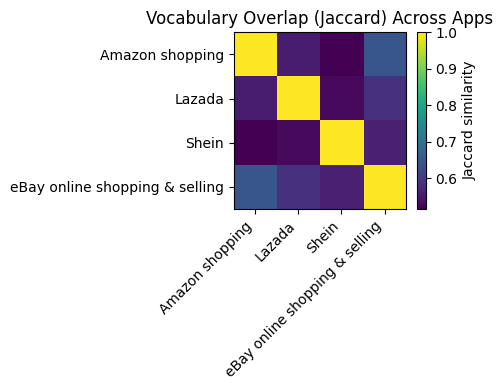

In [63]:
# 词汇重叠（Jaccard 相似度）热力图：各 App 的词表交并比
def jaccard_heatmap(tok_df, topk=None, fname="jaccard_vocab_heatmap.png"):
    if topk is not None:
        wc = tok_df.groupby(["AppName","word"]).size().reset_index(name="count")
        wc = wc.sort_values(["AppName","count"], ascending=[True, False])
        wc = wc.groupby("AppName").head(topk)
        vocab_map = {app:set(g["word"].tolist()) for app, g in wc.groupby("AppName")}
    else:
        vocab_map = {app:set(g["word"].tolist()) for app, g in tok_df.groupby("AppName")}
    apps = list(vocab_map.keys())
    n = len(apps)
    M = np.zeros((n,n), dtype=float)
    for i,a in enumerate(apps):
        for j,b in enumerate(apps):
            inter = len(vocab_map[a] & vocab_map[b])
            union = len(vocab_map[a] | vocab_map[b]) or 1
            M[i,j] = inter/union
    plt.figure(figsize=(1.2*n, 1.0*n))
    plt.imshow(M, aspect="auto")
    plt.xticks(range(n), apps, rotation=45, ha="right")
    plt.yticks(range(n), apps)
    plt.colorbar(label="Jaccard similarity")
    plt.title("Vocabulary Overlap (Jaccard) Across Apps")
    plt.tight_layout()
    savefig(os.path.join(FIG_DIR, fname))

jaccard_heatmap(tok, topk=500, fname="jaccard_vocab_heatmap.png")




**Sentiment Analysis**

In [64]:

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    _ = nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

In [78]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

def _slugify(s):
    """把标题安全地变成文件名"""
    return re.sub(r'[^A-Za-z0-9]+', '_', str(s)).strip('_')

# 4.1 拆分版：分别保存“总览直方图 + 按 App 直方图”
def plot_sentiment_histograms_split(
    df,
    fname_prefix="sentiment_hist",   # 文件名前缀
    bins=40,
    palette=None,
    use_style=True,
    apps_order=None,                 # 可指定顺序；不传则按数据中的顺序
    xlim=(-1, 1),                    # 统一 x 轴范围
    figsize=(8, 5),                  # 单图尺寸
    dpi=300
):
    if use_style:
        plt.style.use("bmh")

    if palette is None:
        palette = [
            "#4C78A8", "#F58518", "#54A24B", "#EECA3B",
            "#B279A2", "#FF9DA6", "#9C755F", "#17BECF",
            "#76B7B2", "#59A14F"
        ]

    saved_paths = []

    # 0) Overall
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(alpha=0.25, linestyle="--", linewidth=0.6)
    for s in ("top", "right"):
        ax.spines[s].set_alpha(0.2)

    overall = df["sentiment_score"].dropna()
    ax.hist(overall, bins=bins, color=palette[0], edgecolor="white", linewidth=0.6, alpha=0.9)
    mu = overall.mean()
    ax.axvline(mu, color="#2C3E50", linestyle="--", linewidth=1.2, label=f"Mean {mu:.2f}")
    ax.set_xlim(*xlim)
    ax.set_title("Overall Sentiment Score Distribution")
    ax.set_xlabel("VADER compound"); ax.set_ylabel("Frequency")
    ax.legend(frameon=False)

    out0 = os.path.join(FIG_DIR, f"{fname_prefix}_overall.png")
    fig.savefig(out0, dpi=dpi, bbox_inches="tight"); plt.close(fig)
    saved_paths.append(out0)

    # 1..k) Each App
    if apps_order is None:
        apps = df["AppName"].dropna().unique().tolist()
    else:
        apps = apps_order

    for i, app in enumerate(apps, start=1):
        sub = df.loc[df["AppName"] == app, "sentiment_score"].dropna()
        if sub.empty:
            continue

        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(alpha=0.25, linestyle="--", linewidth=0.6)
        for s in ("top", "right"):
            ax.spines[s].set_alpha(0.2)

        color = palette[i % len(palette)]
        ax.hist(sub, bins=bins, color=color, edgecolor="white", linewidth=0.6, alpha=0.9)
        mu = sub.mean()
        ax.axvline(mu, color="#2C3E50", linestyle="--", linewidth=1.2, label=f"Mean {mu:.2f}")
        ax.set_xlim(*xlim)
        ax.set_title(str(app))
        ax.set_xlabel("VADER compound"); ax.set_ylabel("Frequency")
        ax.legend(frameon=False)

        outf = os.path.join(FIG_DIR, f"{fname_prefix}_{_slugify(app)}.png")
        fig.savefig(outf, dpi=dpi, bbox_inches="tight"); plt.close(fig)
        saved_paths.append(outf)

    print("[figs saved]")
    for p in saved_paths:
        print("  -", p)
    return saved_paths


In [79]:
apps_order = ["Amazon shopping", "eBay online shopping & selling", "Shein", "Lazada"]
plot_sentiment_histograms_split(df, fname_prefix="sent_hist", apps_order=apps_order)


[figs saved]
  - ../results/figures/sent_hist_overall.png
  - ../results/figures/sent_hist_Amazon_shopping.png
  - ../results/figures/sent_hist_eBay_online_shopping_selling.png
  - ../results/figures/sent_hist_Shein.png
  - ../results/figures/sent_hist_Lazada.png


['../results/figures/sent_hist_overall.png',
 '../results/figures/sent_hist_Amazon_shopping.png',
 '../results/figures/sent_hist_eBay_online_shopping_selling.png',
 '../results/figures/sent_hist_Shein.png',
 '../results/figures/sent_hist_Lazada.png']



*All panels use **VADER compound** scores (−1 = very negative, +1 = very positive). The **dashed line** marks the **mean** for that distribution.*


## 1) Overall Sentiment Score Distribution
- **What it shows:** Distribution of sentiment for the **entire corpus**.  
- **Read it:** Most mass lies **above 0**; the **mean ~0.3**.  
- **Conclusion:** The dataset is **net positive** overall, with a small bump near **0** indicating many **neutral/templated** texts.


## 2) Amazon shopping
- **What it shows:** Sentiment for texts labeled “Amazon shopping.”  
- **Read it:** Distribution is **spread out** with a **sharp spike near 0**; mean only **slightly positive** (~0.1–0.2).  
- **Conclusion:** Tone is **mixed/neutral-leaning**. The spike near zero suggests lots of **informational or templated** content; frequent terms like *can’t/don’t/delivery* align with **issue/logistics** topics.


## 3) eBay online shopping & selling
- **What it shows:** eBay-related sentiment.  
- **Read it:** Mass concentrated in **0.4–0.9**, with a **short negative tail**; **mean ~0.4**.  
- **Conclusion:** eBay content is **more positive** on average—consistent with top words like **easy**, **great**, **good**, **find**.


## 4) Shein
- **What it shows:** Shein-related sentiment.  
- **Read it:** **Heavily right-skewed**; many scores in **0.8–1.0**; **mean ~0.6** (or higher).  
- **Conclusion:** **Strongly positive** tone, matching fashion-style vocabulary (e.g., **love**, **good**, **quality**, **clothes**). Note that brand style and **short exclamations** can inflate positivity in VADER.


## 5) Lazada
- **What it shows:** Lazada-related sentiment.  
- **Read it:** **Positively skewed** but **more variable**; **mean ~0.25–0.3**.  
- **Conclusion:** **Moderately positive** overall, with a noticeable mix of **neutral/mildly negative** items.


## Overall Takeaways
- The corpus is **net positive**.  
- **Positivity ranking (approx.):** **Shein** > **eBay** > **Lazada** > **Amazon**.  
- **Amazon** looks the most **neutral/mixed**, likely due to **templated/informational** responses and **issue-oriented** topics.


## Caveats
- **Model fit:** **VADER** works well for social media but may **over-score brief praise** (e.g., “**love!**”) and under-handle **sarcasm/domain jargon** (e.g., shipping terms).  
- **Context effects:** Platform type, product category (e.g., **fashion vs. logistics**), and **author type** (user vs. platform) can shift distributions.  
- **Comparability:** Differences in **text length**, **topic mix**, and **sampling** across platforms also affect the shape of these histograms.


[fig] saved -> ../results/figures/sentiment_share_by_app.png


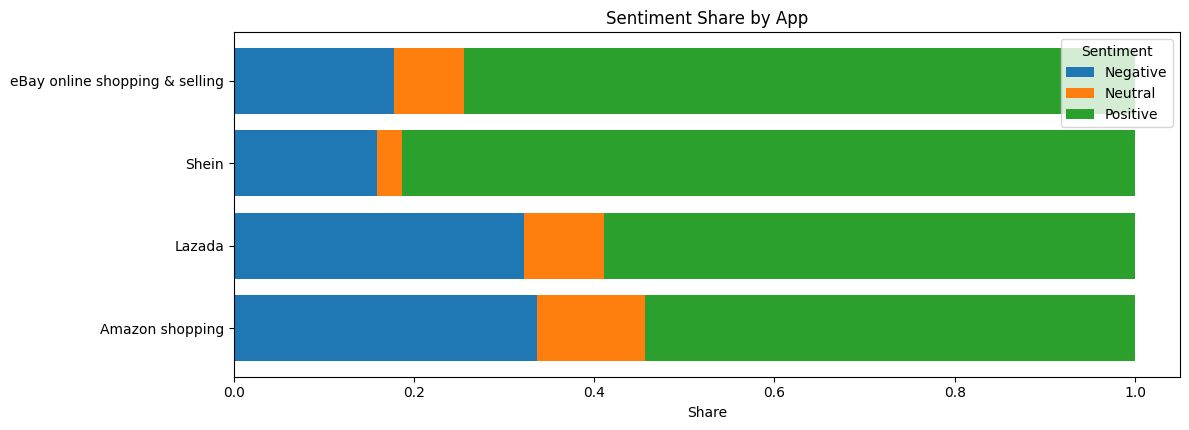

In [66]:
# App 情感占比条形图
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_sentiment_share(sp: pd.DataFrame, fname: str = "sentiment_share_by_app.png"):
    cats = ["Negative", "Neutral", "Positive"]
    sp2 = sp.copy()
    sp2["sentiment_category"] = pd.Categorical(sp2["sentiment_category"], categories=cats, ordered=True)
    wide = (
        sp2.pivot_table(index="AppName", columns="sentiment_category", values="share", aggfunc="sum")
           .reindex(columns=cats)
           .fillna(0.0)
    )

    apps = wide.index.tolist()
    bottom = np.zeros(len(apps), dtype=float)

    plt.figure(figsize=(12, 0.6*len(apps) + 2))
    for cat in cats:
        vals = wide[cat].to_numpy(dtype=float)
        plt.barh(apps, vals, left=bottom, label=cat)
        bottom += vals

    plt.legend(title="Sentiment")
    plt.xlabel("Share")
    plt.title("Sentiment Share by App")
    plt.tight_layout()
    out_path = os.path.join(FIG_DIR, fname)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"[fig] saved -> {out_path}")
plot_sentiment_share(sent_pct)




**Legend:** Blue = **Negative**, Orange = **Neutral**, Green = **Positive**.  
Each horizontal bar sums to **1.0** (share within an app).

## Overall
- All apps are **net positive**, but the **positive share** varies across platforms.

## By App (approximate shares for presentation)
- **Amazon shopping:** **Negative ~33%**, **Neutral ~12%**, **Positive ~55%** → **Mixed/neutral-leaning** profile; sizable issue- or info-oriented content.
- **Lazada:** **Negative ~33%**, **Neutral ~9%**, **Positive ~58%** → Similar to Amazon; **moderate positivity** with relatively higher negative share.
- **Shein:** **Negative ~16%**, **Neutral ~3%**, **Positive ~81%** → **Strongly positive**; very little neutral content (more expressive praise/adjectives).
- **eBay online shopping & selling:** **Negative ~17%**, **Neutral ~8%**, **Positive ~75%** → **Broadly positive**, second only to Shein.

## Key Takeaways
- **Positivity ranking:** **Shein > eBay > Lazada ≈ Amazon**.  
- **Operational implication:** Shein/eBay show concentrated satisfaction language; Amazon/Lazada merit attention to the relatively higher **issue-oriented** and **neutral/informational** comments (e.g., logistics, features, processes).

## Caveats
- Uses **VADER** (lexicon–rule based). It can **over-score short praise** and under-handle **sarcasm/domain jargon**.  
- Differences in **text length**, **topic mix**, and **sampling** across platforms affect comparability.
